In [2]:
from xopto.mcml import mc
from xopto.cl import clinfo
from xopto.materials.absorption import oxyhem, deoxyhem

import numpy as np
import matplotlib.pyplot as pp

In [3]:
cl_device = clinfo.gpu()

In [4]:
# DEFINE RELEVANT SIMULATION PARAMETERS
nphotons = 1e6
wavelengths = np.arange(450e-9, 801e-9, 2e-9)

In [6]:
def normal_skin_layers(wavelength):
    # layer 1 - EPIDERMIS
    d1 = 100e-6  # layer thickness in m
    n1 = 1.4  # refractive index
    m = 0.02  # melanin volume fraction
    g1 = 0.8  # anisotropy factor constant with wavelength
    pf1 = mc.mcpf.Hg(g1)  # Henyey-Greenstein scattering phase function

    # epidermis absortpion coefficient
    mua1 = m * 6.6*1e13*(1e9*wavelength)**-3.33 + \
        (1-m) * 1e2*0.5*(0.244 + 85.3*np.exp(-(1e9*wavelength - 154)/66.2))

    # epidermis scattering coefficient
    mus1 = (2*1e7*(1e9*wavelength)**-1.5 + \
        2*1e14*(1e9*wavelength)**-4) / (1-g1)
    
    # layer 2 - DERMIS
    d2 = 10e-3  # layer thickness in m
    n2 = 1.4  # refractive index
    bl = 0.02  # blood volume fraction
    oxy = 0.90  # oxygenation
    g2 = 0.8  # anisotropy factor
    pf2 = mc.mcpf.Hg(g2)  # Henyey-Greenstein scattering phase function

    # dermis absorption coefficient
    mua_oxy = oxyhem.OxyHem()
    mua_deoxy = deoxyhem.DeOxyHem()

    mua2 = bl * (oxy * mua_oxy(wavelength, None) + \
        (1-oxy) * mua_deoxy(wavelength, None)) + \
        (1-bl) * 1e2 * (0.244 + 16.82*np.exp(-(1e9*wavelength - 400) / 80.5))

    # dermis scattering coefficient
    mus2 = (2*1e7*(1e9*wavelength)**-1.5 + \
        2*1e14*(1e9*wavelength)**-4) / (1-g2)

    return mc.mclayer.Layers([
        mc.mclayer.Layer(d=0.0, n=1.0, mua=0.0, mus=0.0, pf=pf1),  # layer above the medium
        mc.mclayer.Layer(d=d1, n=n1, mua=mua1, mus=mus1, pf=pf1),
        mc.mclayer.Layer(d=d2, n=n2, mua=mua2, mus=mus2, pf=pf2),
        mc.mclayer.Layer(d=0.0, n=1.0, mua=0.0, mus=0.0, pf=pf1),  # layer below the medium
        ])

In [7]:
def hemangioma_skin_layers(wavelength):
    # — Epidermis —
    d1, n1, m, g1 = 100e-6, 1.4, 0.02, 0.8
    pf1 = mc.mcpf.Hg(g1)
    mua1 = ( m*6.6e13*(1e9*wavelength)**-3.33
            + (1-m)*1e2*0.5*(0.244+85.3*np.exp(-(1e9*wavelength-154)/66.2)) )
    mus1 = (2e7*(1e9*wavelength)**-1.5 + 2e14*(1e9*wavelength)**-4)/(1-g1)

    # — Hemangioma lesion layer —
    d2, n2, bl2, oxy2, g2 = 2e-3, 1.4, 0.15, 0.75, 0.8
    pf2 = mc.mcpf.Hg(g2)
    mua_oxy = oxyhem.OxyHem()
    mua_deoxy = deoxyhem.DeOxyHem()
    mua2 = ( bl2*(oxy2*mua_oxy(wavelength,None) + (1-oxy2)*mua_deoxy(wavelength,None))
            + (1-bl2)*1e2*1.2*(0.244+16.82*np.exp(-(1e9*wavelength-400)/80.5)) )
    mus2 = 1.1*(2e7*(1e9*wavelength)**-1.5 + 2e14*(1e9*wavelength)**-4)/(1-g2)

    # — Remaining normal dermis —
    # subtract your lesion thickness from the original dermis (10 mm total)
    d3 = 10e-3 - d2  
    n3, bl3, oxy3, g3 = 1.4, 0.02, 0.90, 0.8
    pf3 = mc.mcpf.Hg(g3)
    mua3 = ( bl3*(oxy3*mua_oxy(wavelength,None) + (1-oxy3)*mua_deoxy(wavelength,None))
            + (1-bl3)*1e2*(0.244+16.82*np.exp(-(1e9*wavelength-400)/80.5)) )
    mus3 = (2e7*(1e9*wavelength)**-1.5 + 2e14*(1e9*wavelength)**-4)/(1-g3)

    return mc.mclayer.Layers([
        mc.mclayer.Layer(d=0.0, n=1.0, mua=0.0,   mus=0.0,   pf=pf1),
        mc.mclayer.Layer(d=d1,  n=n1,  mua=mua1, mus=mus1, pf=pf1),
        mc.mclayer.Layer(d=d2,  n=n2,  mua=mua2, mus=mus2, pf=pf2),
        mc.mclayer.Layer(d=d3,  n=n3,  mua=mua3, mus=mus3, pf=pf3),
        mc.mclayer.Layer(d=0.0, n=1.0, mua=0.0,   mus=0.0,   pf=pf1),
    ])

In [8]:
# DEFINE SOURCE
source = mc.mcsource.Line(
    position=(0.0, 0.0, 0.0),
    direction=(0.0, 0.0, 1.0)
)

# DEFINE A DETECTOR FOR INTEGRATING SPHERE
sp_r = 0.5e-2  # integrating sphere opening in m
detector_top = mc.mcdetector.Radial(
    mc.mcdetector.RadialAxis(
        start=0.0,
        stop=2*sp_r,
        n=2)
)
detectors = mc.mcdetector.Detectors(
    top=detector_top
)

In [11]:
reflectance_spectrum = {
    'normal': np.zeros(len(wavelengths)),
    'hemangioma': np.zeros(len(wavelengths))
}
for i, w in enumerate(wavelengths):
    normal_layers = normal_skin_layers(w)
    hemangioma_layers = hemangioma_skin_layers(w)
    skins = [normal_layers, hemangioma_layers]

    for skin in skins:
        mc_obj = mc.Mc(
            layers=skin,
            source=source,
            detectors=detectors,
            cl_devices=cl_device
        )
        mc_obj.rmax = 10e-2

        detector = mc_obj.run(nphotons, verbose=True)[-1]
        if skin is normal_layers:
            reflectance_spectrum['normal'][i] = detector.top.reflectance[0] * np.pi * sp_r**2
        else:
            reflectance_spectrum['hemangioma'][i] = detector.top.reflectance[0] * np.pi * sp_r**2

OpenCL source files fused in 8.312434 ms.
Executing OpenCL code on: [<pyopencl.Device 'Intel(R) Iris(R) Xe Graphics' on 'Intel(R) OpenCL Graphics' at 0x567fb0dcb7e0>]
OpenCL build options: []
Source code built in 2.106 ms.
OpenCL engine created in 52.074 ms.
McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:     63.381 ms
    executed in      :     48.295 ms
    downloaded in    :      1.171 ms
OpenCL source files fused in 7.373281 ms.
Executing OpenCL code on: [<pyopencl.Device 'Intel(R) Iris(R) Xe Graphics' on 'Intel(R) OpenCL Graphics' at 0x567fb0dcb7e0>]
OpenCL build options: []
Source code built in 1.889 ms.
OpenCL engine created in 43.788 ms.
McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:     52.606 ms
    executed in      :     29.361 ms
    downloaded in    :      1.081 ms
OpenCL source files fused in 7.519094 ms.
Executing OpenCL code on: [<pyopencl.Device 'Intel(R) Iris(R) Xe Graphics' on 'Intel(R) OpenCL Graphics' at 

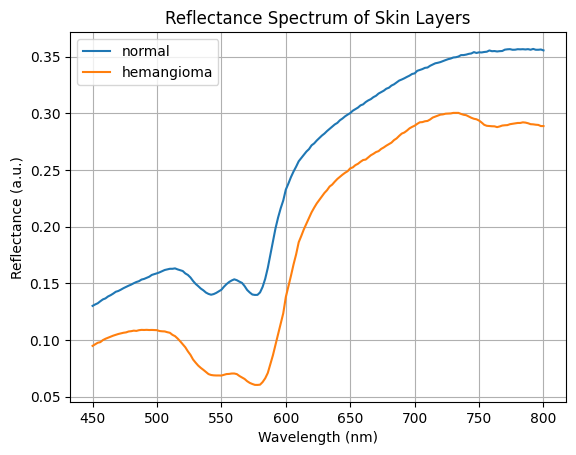

In [12]:
for key, spectrum in reflectance_spectrum.items():
    pp.plot(wavelengths * 1e9, spectrum, label=key)
pp.xlabel('Wavelength (nm)')
pp.ylabel('Reflectance (a.u.)')
pp.title('Reflectance Spectrum of Skin Layers')
pp.legend()
pp.grid()
pp.show()